In [197]:
import warnings
warnings.filterwarnings("ignore")

In [198]:
import os
import time
import sklearn
import random
import numpy as np
import problexity as px
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [199]:
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add
name_list=find_the_way('./','.csv')
name_list=['./csv\\DoS-SYN-1.csv',
 './csv\\DoS-SYN-2.csv',
 './csv\\DoS-SYN-3.csv',
 './csv\\DoS-SYN-4.csv',
 './csv\\DoS-SYN-5.csv',
 './csv\\DoS-SYN-6.csv']

In [200]:
feature=['ts',
 #'Ether_dst',
 #'Ether_src',
 #'IP_src',
 #'IP_dst',
 'pck_size',
 'Ether_type',
 'LLC_dsap',
 'LLC_ssap',
 'LLC_ctrl',
 'EAPOL_version',
 'EAPOL_type',
 'EAPOL_len',
 'IP_version',
 'IP_ihl',
 'IP_tos',
 'IP_len',

 'IP_Z',


 #'IP_chksum',

 'IP_frag',
 'IP_ttl',
 'IP_proto',
 'IP_options',
 'ICMP_type',
 'ICMP_code',
 'ICMP_chksum',
 'ICMP_id',
 'ICMP_seq',
 'ICMP_ts_ori',
 'ICMP_ts_rx',
 'ICMP_ts_tx',
 'ICMP_ptr',
 'ICMP_reserved',
 'ICMP_length',
 'ICMP_nexthopmtu',
 #'ICMP_unused',
 
 'TCP_dataofs',
 'TCP_reserved',

 'TCP_FIN',

 'TCP_RST',
 'TCP_PSH',

 'TCP_URG',
 'TCP_ECE',
 'TCP_CWR',


 'TCP_urgptr',
 'TCP_options',
 'UDP_len',
 'UDP_chksum',
 'DHCP_options',
 'BOOTP_op',
 'BOOTP_htype',
 'BOOTP_hlen',
 'BOOTP_hops',
 'BOOTP_xid',
 'BOOTP_secs',
 'BOOTP_flags',
 'BOOTP_sname',
 'BOOTP_file',
 'BOOTP_options',
 'DNS_length',
 'DNS_id',
 'DNS_qr',
 'DNS_opcode',
 'DNS_aa',
 'DNS_tc',
 'DNS_rd',
 'DNS_ra',
 'DNS_z',
 'DNS_ad',
 'DNS_cd',
 'DNS_rcode',
 'DNS_qdcount',
 'DNS_ancount',
 'DNS_nscount',
 'DNS_arcount',

 'Label']



In [201]:
cols=["pck_size","Label"]
comp={}

for file in tqdm(name_list):
        df= pd.read_csv(file,usecols=cols)
        df = df.loc[:, (df != 0).any(axis=0)]
        anormal=df[df["Label"]==1]
        normal=df[df["Label"]==0]
        if len (anormal)>1000:
            anormal=anormal.sample(n=1000,random_state=42)
        if len (normal)>1000:
            normal=normal.sample(n=1000,random_state=42)

        df =  pd.concat([anormal,normal])
        df=df.fillna(-1)
        y=df["Label"]
        del df["Label"]
        df['pck_size'] = df['pck_size'].astype(float)        
        for i in df.columns:
            if len(df[i].unique())<2:
                del df[i]
        X=df.values       
        df["Label"]=y
        y = y.astype('category')
        y=y.cat.codes
        y=y.values
      
        cc = px.ComplexityCalculator()
        cc.fit(X,y)
        #colname=f"{file[9:-4]}"
        temp=list(cc.complexity)
        x=(temp[0]+temp[1]+temp[3]+temp[4]+temp[12]+temp[13])/6
        comp[file]=[x,cc.score()]



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:25<00:00, 34.22s/it]


In [209]:
temp={}
for ii,i in enumerate(comp):
    print(comp[i])
    temp[str(ii)]=comp[i]


comp=temp
comp

[0.7087813029921692, 0.32679554791820936]
[0.7138555492393829, 0.38109496146999744]
[0.688902076616298, 0.313481295863107]
[0.8488459743014903, 0.4370281078351775]
[0.9664167829323417, 0.4909659734486912]
[0.9760443836388429, 0.5003786127586464]


{'0': [0.7087813029921692, 0.32679554791820936],
 '1': [0.7138555492393829, 0.38109496146999744],
 '2': [0.688902076616298, 0.313481295863107],
 '3': [0.8488459743014903, 0.4370281078351775],
 '4': [0.9664167829323417, 0.4909659734486912],
 '5': [0.9760443836388429, 0.5003786127586464]}

In [143]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [144]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [145]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

In [146]:
ml_list={"DT":DecisionTreeClassifier()}

In [147]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [148]:
folder("results")
folder("pdfs")

## Calculation of evaluations

In [149]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [150]:
def ML_CV(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=10

    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  




            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()

In [152]:
for e1,i in enumerate(name_list):
    for e2,ii in enumerate(name_list):
        if i!=ii:
            train=i
            test=ii
            #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
            print(feature)
            output_csv=f"./results/val/{e1}_{e2}_chosed_output_ML_.csv"
            target_names=[1,0]
            ML_CV(train,test,output_csv,feature,file,5)  


['ts', 'pck_size', 'Ether_type', 'LLC_dsap', 'LLC_ssap', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'EAPOL_len', 'IP_version', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_Z', 'IP_frag', 'IP_ttl', 'IP_proto', 'IP_options', 'ICMP_type', 'ICMP_code', 'ICMP_chksum', 'ICMP_id', 'ICMP_seq', 'ICMP_ts_ori', 'ICMP_ts_rx', 'ICMP_ts_tx', 'ICMP_ptr', 'ICMP_reserved', 'ICMP_length', 'ICMP_nexthopmtu', 'TCP_dataofs', 'TCP_reserved', 'TCP_FIN', 'TCP_RST', 'TCP_PSH', 'TCP_URG', 'TCP_ECE', 'TCP_CWR', 'TCP_urgptr', 'TCP_options', 'UDP_len', 'UDP_chksum', 'DHCP_options', 'BOOTP_op', 'BOOTP_htype', 'BOOTP_hlen', 'BOOTP_hops', 'BOOTP_xid', 'BOOTP_secs', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_length', 'DNS_id', 'DNS_qr', 'DNS_opcode', 'DNS_aa', 'DNS_tc', 'DNS_rd', 'DNS_ra', 'DNS_z', 'DNS_ad', 'DNS_cd', 'DNS_rcode', 'DNS_qdcount', 'DNS_ancount', 'DNS_nscount', 'DNS_arcount', 'Label']
    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T  

    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  -------------------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ./csv\DoS-SYN-1.csv     5    1     0  DT    0.522    0.533   0.75   0.533  0.398  0.065  0.533    0.013     0.003
 1  ./csv\DoS-SYN-1.csv     5    1     1  DT    0.522    0.533   0.75   0.533  0.399  0.065  0.533    0.012     0.002
 2  ./csv\DoS-SYN-1.csv     5    1     2  DT    0.523    0.535   0.752  0.535  0.401  0.068  0.535    0.014     0.004
 3  ./csv\DoS-SYN-1.csv     5    1     3  DT    0.523    0.535   0.752  0.535  0.401  0.068  0.535    0.015     0.003
 4  ./csv\DoS-SYN-1.csv     5    1     4  DT    0.522    0.534   0.752  0.534  0.399  0.066  0.534    0.01      0.003
 5  ./csv\DoS-SYN-1.csv     5    1     5  DT    0.523    0.535   0.752  0.535  0.401  0.068  0.535    0.002     0
 6  ./csv\DoS-SYN-1.csv     5    1     6  DT    0.522    0.5

    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  -------------------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ./csv\DoS-SYN-1.csv     5    1     0  DT    0.526    0.537   0.749  0.537  0.407  0.073  0.537    0.019     0.002
 1  ./csv\DoS-SYN-1.csv     5    1     1  DT    0.526    0.537   0.749  0.537  0.407  0.073  0.537    0.022     0.002
 2  ./csv\DoS-SYN-1.csv     5    1     2  DT    0.526    0.537   0.749  0.537  0.407  0.073  0.537    0.014     0.002
 3  ./csv\DoS-SYN-1.csv     5    1     3  DT    0.526    0.537   0.749  0.537  0.407  0.073  0.537    0.02      0
 4  ./csv\DoS-SYN-1.csv     5    1     4  DT    0.526    0.537   0.749  0.537  0.407  0.073  0.537    0.022     0.001
 5  ./csv\DoS-SYN-1.csv     5    1     5  DT    0.526    0.537   0.749  0.537  0.407  0.073  0.537    0.016     0.002
 6  ./csv\DoS-SYN-1.csv     5    1     6  DT    0.526    0.5

    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  -------------------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ./csv\DoS-SYN-1.csv     5    1     0  DT    0.653    0.688   0.781  0.688  0.633  0.348  0.688    0.018     0
 1  ./csv\DoS-SYN-1.csv     5    1     1  DT    0.653    0.688   0.781  0.688  0.633  0.348  0.688    0.016     0.003
 2  ./csv\DoS-SYN-1.csv     5    1     2  DT    0.653    0.688   0.781  0.688  0.633  0.348  0.688    0.01      0
 3  ./csv\DoS-SYN-1.csv     5    1     3  DT    0.653    0.688   0.781  0.688  0.633  0.348  0.688    0.01      0.004
 4  ./csv\DoS-SYN-1.csv     5    1     4  DT    0.653    0.688   0.781  0.688  0.633  0.348  0.688    0.01      0.005
 5  ./csv\DoS-SYN-1.csv     5    1     5  DT    0.653    0.688   0.781  0.688  0.633  0.348  0.688    0.015     0
 6  ./csv\DoS-SYN-1.csv     5    1     6  DT    0.653    0.688   0.7

    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  -------------------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ./csv\DoS-SYN-1.csv     5    1     0  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0         0
 1  ./csv\DoS-SYN-1.csv     5    1     1  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0
 2  ./csv\DoS-SYN-1.csv     5    1     2  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0         0
 3  ./csv\DoS-SYN-1.csv     5    1     3  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0         0
 4  ./csv\DoS-SYN-1.csv     5    1     4  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0
 5  ./csv\DoS-SYN-1.csv     5    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0         0
 6  ./csv\DoS-SYN-1.csv     5    1     6  DT    0.999    0.999   0.999  0.999  0

    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  -------------------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ./csv\DoS-SYN-1.csv     5    1     0  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0         0
 1  ./csv\DoS-SYN-1.csv     5    1     1  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.016     0
 2  ./csv\DoS-SYN-1.csv     5    1     2  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0         0.016
 3  ./csv\DoS-SYN-1.csv     5    1     3  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0         0.016
 4  ./csv\DoS-SYN-1.csv     5    1     4  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0         0
 5  ./csv\DoS-SYN-1.csv     5    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.01      0.007
 6  ./csv\DoS-SYN-1.csv     5    1     6  DT    0.999    0.999   0.9

    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  -------------------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ./csv\DoS-SYN-1.csv     5    1     0  DT    0.999    0.999   0.999  0.999  0.999  0.997  0.999    0         0
 1  ./csv\DoS-SYN-1.csv     5    1     1  DT    0.999    0.999   0.999  0.999  0.999  0.997  0.999    0         0
 2  ./csv\DoS-SYN-1.csv     5    1     2  DT    0.999    0.999   0.999  0.999  0.999  0.997  0.999    0.016     0
 3  ./csv\DoS-SYN-1.csv     5    1     3  DT    0.998    0.998   0.998  0.998  0.998  0.997  0.998    0.016     0
 4  ./csv\DoS-SYN-1.csv     5    1     4  DT    0.999    0.999   0.999  0.999  0.999  0.997  0.999    0.016     0
 5  ./csv\DoS-SYN-1.csv     5    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.997  0.999    0         0.016
 6  ./csv\DoS-SYN-1.csv     5    1     6  DT    0.999    0.999   0.999  0.99

    Dataset                SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  -------------------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ./csv\DoS-SYN-1.csv     5    1     0  DT    0.994    0.994   0.994  0.994  0.994  0.987  0.994    0         0
 1  ./csv\DoS-SYN-1.csv     5    1     1  DT    0.994    0.994   0.994  0.994  0.994  0.987  0.994    0.016     0
 2  ./csv\DoS-SYN-1.csv     5    1     2  DT    0.994    0.994   0.994  0.994  0.994  0.987  0.994    0.012     0
 3  ./csv\DoS-SYN-1.csv     5    1     3  DT    0.994    0.994   0.994  0.994  0.994  0.987  0.994    0         0.017
 4  ./csv\DoS-SYN-1.csv     5    1     4  DT    0.994    0.994   0.994  0.994  0.994  0.987  0.994    0         0
 5  ./csv\DoS-SYN-1.csv     5    1     5  DT    0.994    0.994   0.994  0.994  0.994  0.987  0.994    0.016     0
 6  ./csv\DoS-SYN-1.csv     5    1     6  DT    0.994    0.994   0.994  0.99

In [153]:
files_add=find_the_way(f"./results/val",".csv")
files_add

['./results/val\\0_1_chosed_output_DT_.csv',
 './results/val\\0_2_chosed_output_DT_.csv',
 './results/val\\0_3_chosed_output_DT_.csv',
 './results/val\\0_4_chosed_output_DT_.csv',
 './results/val\\0_5_chosed_output_DT_.csv',
 './results/val\\1_0_chosed_output_DT_.csv',
 './results/val\\1_2_chosed_output_DT_.csv',
 './results/val\\1_3_chosed_output_DT_.csv',
 './results/val\\1_4_chosed_output_DT_.csv',
 './results/val\\1_5_chosed_output_DT_.csv',
 './results/val\\2_0_chosed_output_DT_.csv',
 './results/val\\2_1_chosed_output_DT_.csv',
 './results/val\\2_3_chosed_output_DT_.csv',
 './results/val\\2_4_chosed_output_DT_.csv',
 './results/val\\2_5_chosed_output_DT_.csv',
 './results/val\\3_0_chosed_output_DT_.csv',
 './results/val\\3_1_chosed_output_DT_.csv',
 './results/val\\3_2_chosed_output_DT_.csv',
 './results/val\\3_4_chosed_output_DT_.csv',
 './results/val\\3_5_chosed_output_DT_.csv',
 './results/val\\4_0_chosed_output_DT_.csv',
 './results/val\\4_1_chosed_output_DT_.csv',
 './result

In [154]:
results=[['train','test', 'Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    df=df[3:]

    temp=(i[14:-22].split("_"))
    temp=temp+df
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 496.52it/s]


In [155]:
results

,train,test,Acc,b_Acc,Prec,Rec,F1,kap,ROC,tra-T,test-T
0,0,1,0.993130,0.993964,0.992108,0.993964,0.992991,0.985983,0.993964,0.010391,0.005620
1,0,2,0.998810,0.998833,0.998783,0.998833,0.998808,0.997615,0.998833,0.012539,0.005328
2,0,3,0.653754,0.688473,0.781002,0.688473,0.633552,0.349624,0.688473,0.012892,0.001586
3,0,4,0.523245,0.534298,0.750102,0.534298,0.400426,0.067077,0.534298,0.010164,0.005031
4,0,5,0.522705,0.533955,0.751199,0.533955,0.399521,0.066380,0.533955,0.011626,0.002148
5,1,0,0.999550,0.999546,0.999548,0.999546,0.999547,0.999094,0.999546,0.012852,0.003625
6,1,2,0.998030,0.998018,0.998035,0.998018,0.998026,0.996052,0.998018,0.014775,0.002785
7,1,3,0.653821,0.688447,0.780155,0.688447,0.633772,0.349637,0.688447,0.016077,0.001682
8,1,4,0.526474,0.537445,0.749292,0.537445,0.406860,0.073243,0.537445,0.015437,0.001039
9,1,5,0.535996,0.546928,0.753893,0.546928,0.424983,0.091798,0.546928,0.014797,0.001572


In [195]:
comp={'0': [0.7087813029921692, 0.32672736610002756],
 '1': [0.7138555492393829, 0.3508778081290903],
 '2': [0.688902076616298, 0.3135040231358343],
 '3': [0.8488459743014903, 0.4372781078351775],
 '4': [0.9664167829323417, 0.4901477916305094],
 '5': [0.9760443836388429, 0.4946316887234352]}
sty=["-",":","-.","-",":","-."]
mark=["o","v","^","*","s","D"]

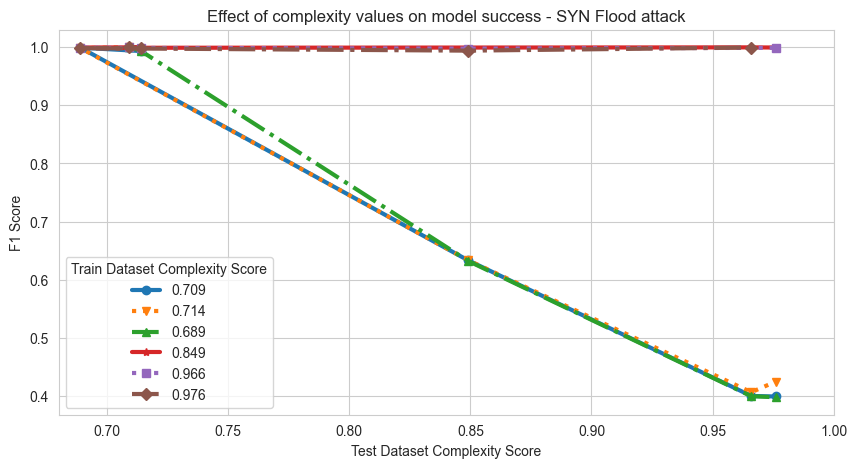

In [210]:
method={"CV":"Cross-validation","SS":"2 Diffirent Sessions","DD":"2 Diffirent Dataset" }
import matplotlib.pylab as pylab
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
for i in results["train"].unique():   
    
    graph_name=f"./pdfs/Comparison_f1_{i}.pdf"
    #plt.margins(x=0)
    sf=results[results["train"]==i]
    my_xticks=[]
    for t in sf.test.values:
        my_xticks.append(round(comp[t][0],3))
    plt.plot(my_xticks,sf['F1'], linestyle=sty[int(i)], marker=mark[int(i)],label= round(comle[i][0],3), linewidth=3,alpha=1)
plt.title(f"Effect of complexity values on model success - SYN Flood attack")
plt.legend(title='Train Dataset Complexity Score',numpoints=1)


#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("F1 Score")
plt.xlabel("Test Dataset Complexity Score")
#plt.xticks(rotation=90) 
plt.xlim([0.68, 1]) 
plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
plt.show()